# Load Libraries

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.metrics import ConfusionMatrixDisplay
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from sklearn.metrics import f1_score

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu')
print(f"Device: {device}")

Device: mps


# Create training and validation dataset.

In [3]:
# Define transforms
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32),
        # Standard scale
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load dataset
data_dir = "realwaste-main/RealWaste"
# Define the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Calculate the sizes of the train and val datasets
train_split = 0.8
train_size = int(train_split * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into train and val datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print the sizes of the train and val datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

num_classes = len(dataset.classes)

Train dataset size: 3801
Val dataset size: 951


In [4]:
# Define dataloaders
batch_size = 64
image_size = 524
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Target variable distribution

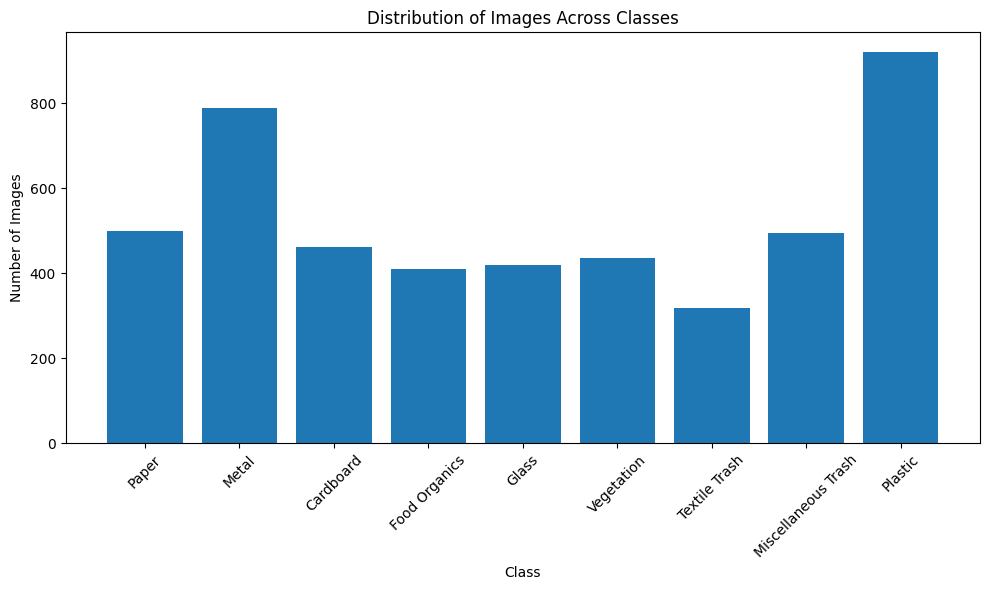

In [5]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Design The Model

In [6]:
# Define model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 9),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CustomModel()

# Select the learning rate, loss function, optimizers and compile the model.

In [7]:
# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adamax(model.parameters(), lr=1e-2)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

summary(model, (batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [64, 9]                   --
├─Sequential: 1-1                        [64, 1024, 4, 4]          --
│    └─Conv2d: 2-1                       [64, 16, 524, 524]        448
│    └─ReLU: 2-2                         [64, 16, 524, 524]        --
│    └─BatchNorm2d: 2-3                  [64, 16, 524, 524]        32
│    └─MaxPool2d: 2-4                    [64, 16, 262, 262]        --
│    └─Conv2d: 2-5                       [64, 32, 262, 262]        4,640
│    └─ReLU: 2-6                         [64, 32, 262, 262]        --
│    └─BatchNorm2d: 2-7                  [64, 32, 262, 262]        64
│    └─MaxPool2d: 2-8                    [64, 32, 131, 131]        --
│    └─Conv2d: 2-9                       [64, 64, 131, 131]        18,496
│    └─ReLU: 2-10                        [64, 64, 131, 131]        --
│    └─BatchNorm2d: 2-11                 [64, 64, 131, 131]        128
│    └

# Train the model and save the checkpoint where the val_loss is improved.

In [8]:
# Train the model
epochs = 30
best_val_loss = float("inf")
model.to(device)
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_f1_score = 0.0
    steps = 0
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # One hot encode labels
        labels = nn.functional.one_hot(labels, num_classes=num_classes).to(
            torch.float32
        )

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_f1_score_step = f1_score(
            labels.argmax(dim=1).cpu(), outputs.argmax(dim=1).cpu(), average="micro"
        )
        train_f1_score += train_f1_score_step
        steps += 1

        print_stmt = f"Epoch {epoch + 1}/{epochs}, Step {step + 1}/{len(train_loader)}, Loss: {loss.item():.4f}, F1 Score: {train_f1_score_step:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.4f}"
        print(print_stmt, end="\r",)
    train_loss /= steps
    train_f1_score /= steps
    train_losses.append(train_loss)
    print(
        f"Epoch {epoch + 1}/{epochs}, Step {steps}/{len(train_loader)}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1_score:.4f}, Learning Rate: {optimizer.param_groups[0]['lr']:.4f}"
    )

    model.eval()
    val_loss = 0.0
    val_f1_score = 0.0
    steps = 0
    with torch.no_grad():
        for step, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            # One hot encode labels
            labels = nn.functional.one_hot(labels, num_classes=num_classes).to(
                torch.float32
            )

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_f1_score_step = f1_score(
                labels.argmax(dim=1).cpu(), outputs.argmax(dim=1).cpu(), average="micro"
            )
            val_f1_score += val_f1_score_step
            steps += 1



            print(
                f"Epoch {epoch + 1}/{epochs}, Step {step + 1}/{len(val_loader)}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1_score_step:.4f}",
                end="\r",
                flush=True,
            )
        val_loss /= steps
        val_f1_score /= steps
        val_losses.append(val_loss)
        print(
            f"Epoch {epoch + 1}/{epochs}, Step {steps}/{len(val_loader)}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1_score:.4f}"
        )

    lr_scheduler.step()

    if val_loss < best_val_loss:
        print(f"Saving model, loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
        best_val_loss = val_loss
        torch.save(model.state_dict(), "pytorch_custom_model.pth")

Epoch 1/30, Step 60/60, Train Loss: 2.0128, Train F1 Score: 0.3532, Learning Rate: 0.0100
Epoch 1/30, Step 15/15, Val Loss: 2.0350, Val F1 Score: 0.33245
Saving model, loss improved from inf to 2.0350
Epoch 2/30, Step 60/60, Train Loss: 1.9397, Train F1 Score: 0.4283, Learning Rate: 0.0100
Epoch 2/30, Step 15/15, Val Loss: 1.9298, Val F1 Score: 0.43677
Saving model, loss improved from 2.0350 to 1.9298
Epoch 3/30, Step 60/60, Train Loss: 1.9115, Train F1 Score: 0.4517, Learning Rate: 0.0100
Epoch 3/30, Step 15/15, Val Loss: 1.9358, Val F1 Score: 0.42494
Epoch 4/30, Step 60/60, Train Loss: 1.8855, Train F1 Score: 0.4798, Learning Rate: 0.0100
Epoch 4/30, Step 15/15, Val Loss: 2.0590, Val F1 Score: 0.29759
Epoch 5/30, Step 60/60, Train Loss: 1.8795, Train F1 Score: 0.4900, Learning Rate: 0.0100
Epoch 5/30, Step 15/15, Val Loss: 1.8969, Val F1 Score: 0.47206
Saving model, loss improved from 1.9298 to 1.8969
Epoch 6/30, Step 60/60, Train Loss: 1.8367, Train F1 Score: 0.5313, Learning Rate: 

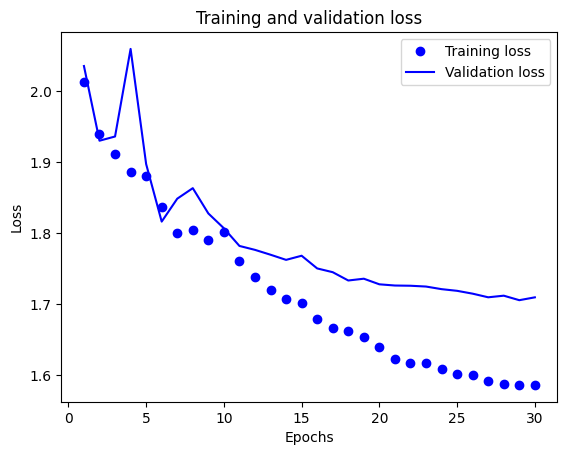

In [13]:
# Plot loss vs epoch graph
plt.plot(range(1, epochs + 1), train_losses, 'bo', label='Training loss')
plt.plot(range(1, epochs + 1), val_losses, 'b', label='Validation loss')  # If you have validation data
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the model and check the accuracy

In [21]:
# Load the best model and evaluate
model.load_state_dict(torch.load('pytorch_custom_model.pth'))

model.eval()
val_loss = 0.0
val_f1_score = 0
y_pred = np.array([])
y_true = np.array([])
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true = np.append(y_true, labels.cpu().numpy())
        
        outputs = model(images)
        # One hot encode labels
        labels = nn.functional.one_hot(labels, num_classes=num_classes).to(
            torch.float32
        )
        y_pred = np.append(y_pred, outputs.argmax(dim=1).cpu().numpy())
        
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        val_f1_score_step = f1_score(
            labels.argmax(dim=1).cpu(), outputs.argmax(dim=1).cpu(), average="micro"
        )
        val_f1_score += val_f1_score_step
val_loss /= len(val_loader.dataset)
val_f1_score = val_f1_score / len(val_loader)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_f1_score)

Validation Loss: 0.026897730511445728
Validation Accuracy: 0.6649999999999999


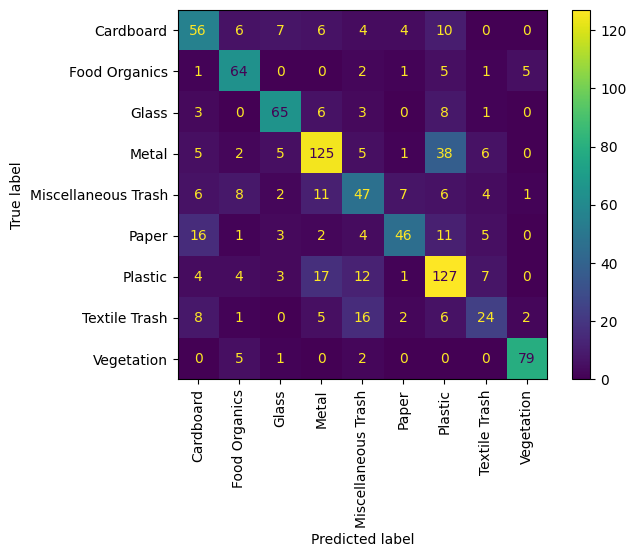

In [24]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=dataset.classes, xticks_rotation='vertical')